In [1]:
import optuna
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks import Callback
from torch.utils.data import DataLoader, TensorDataset
import torch

from models.model_v1 import *
from utils.dataset_loader import MaestroV3DataModule

def objective(trial):
    # Suggest hyperparameters
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    b1 = trial.suggest_uniform('b1', 0.0, 0.9)
    b2 = trial.suggest_uniform('b2', 0.9, 0.999)
    
    lambda_1 = trial.suggest_float('lambda_1', 0.0, 10.0)
    lambda_2 = trial.suggest_float('lambda_2', 0.0, 1.0)

    latent_dim = trial.suggest_int('latent_dim', 50, 200)
    gen_updates = trial.suggest_int('gen_updates', 1, 5)
    dis_updates = trial.suggest_int('dis_updates', 1, 5)

    minibatch_B = trial.suggest_int('minibatch_B', 5, 15)
    minibatch_C = trial.suggest_int('minibatch_C', 1, 8)

    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

    # Dataset.
    data_file_path = "data/preprocessed/maestro-v3.0.0/dataset1/bigger_than.h5"
    dm = MaestroV3DataModule(data_file_path)

    # Initialize model with trial hyperparameters
    model = GAN(latent_dim=latent_dim,
                lr=lr, b1=b1, b2=b2,
                gen_updates=gen_updates,
                dis_updates=dis_updates,
                lambda_1=lambda_1,
                lambda_2=lambda_2,
                minibatch_B=minibatch_B,
                minibatch_C=minibatch_C,
                batch_size=batch_size
    )

    # Logger and callbacks
    checkpoint_callback = ModelCheckpoint(monitor='g_loss', mode='min', save_top_k=1)

    # Trainer
    trainer = Trainer(
        callbacks=[checkpoint_callback],
        max_epochs=5,
        accelerator="auto",
        enable_progress_bar=False
    )

    # Train
    trainer.fit(model, dm)

    # Retrieve best metric
    return checkpoint_callback.best_model_score.item()

/usr/lib/python3.13/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.1 is exactly one major version older than the runtime version 6.31.1 at api.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/usr/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


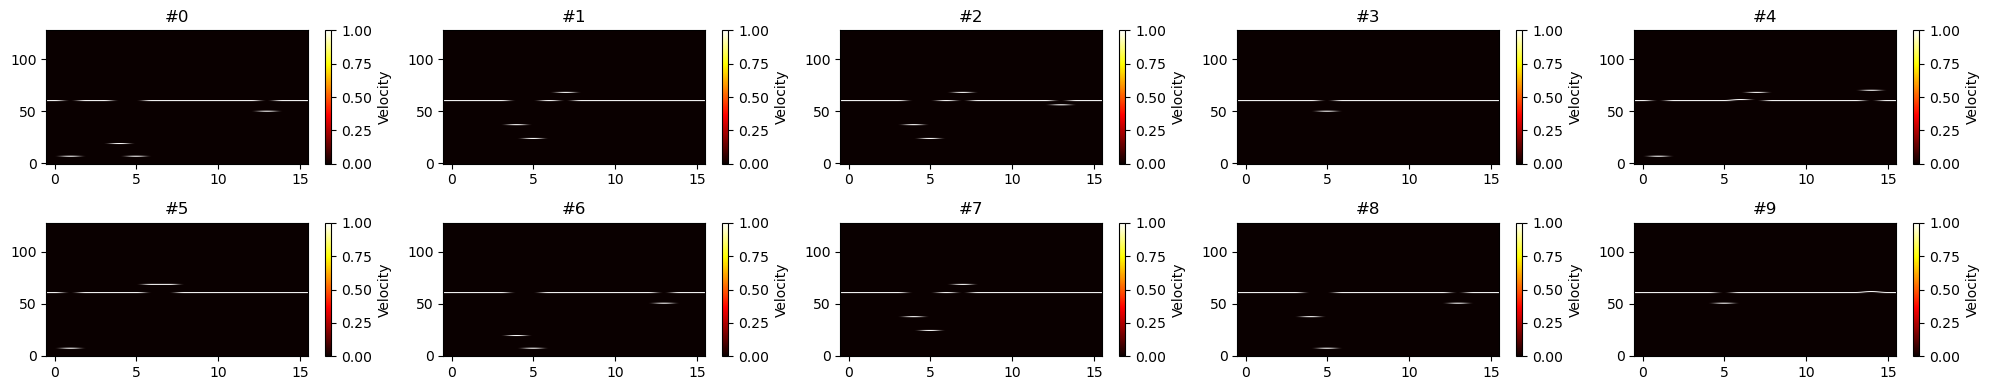

`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2025-07-15 18:06:47,991] Trial 4 finished with value: 4.979855060577393 and parameters: {'lr': 0.0002616295730485957, 'b1': 0.6469576332349039, 'b2': 0.9089424957832437, 'lambda_1': 3.8606534091384215, 'lambda_2': 0.19789136734041035, 'latent_dim': 85, 'gen_updates': 4, 'dis_updates': 4, 'minibatch_B': 5, 'minibatch_C': 4, 'batch_size': 16}. Best is trial 2 with value: 0.807701587677002.


Best trial:
  Value: 0.807701587677002
  Params:
    lr: 0.00010784975564964266
    b1: 0.46048505901509046
    b2: 0.9685907263539504
    lambda_1: 4.482079251593552
    lambda_2: 0.8690755395823718
    latent_dim: 170
    gen_updates: 1
    dis_updates: 1
    minibatch_B: 6
    minibatch_C: 7
    batch_size: 16


In [2]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)
print('Best trial:')
trial = study.best_trial
print(f'  Value: {trial.value}')
print('  Params:')
for key, val in trial.params.items():
    print(f'    {key}: {val}')

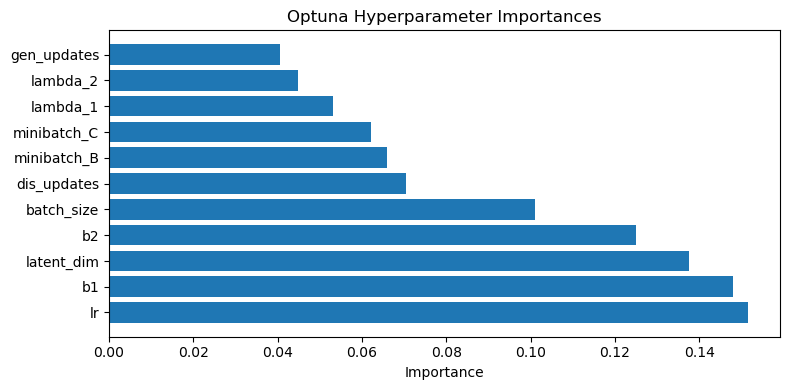

In [3]:
# If you prefer a quick matplotlib bar chart instead of Plotly:
from optuna.importance import get_param_importances
import matplotlib.pyplot as plt

imp = get_param_importances(study)
names = list(imp.keys())
scores = list(imp.values())

plt.figure(figsize=(8,4))
plt.barh(names, scores)
plt.xlabel("Importance")
plt.title("Optuna Hyperparameter Importances")
plt.tight_layout()
plt.show()